In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

file_path = '../data/raw/MachineLearningRating_v3.txt' 


try:
  
    df = pd.read_csv(file_path, sep='|')
    print("Data loaded successfully using '|' as the separator!")

    df.columns = df.columns.str.strip().str.lower()
    print("\nAll column names have been cleaned and standardized to lowercase.")

    print("\nData Types:")
    df.info()

except FileNotFoundError:
    print(f"ERROR: The file was not found at '{file_path}'.")
except Exception as e:
    print(f"An error occurred: {e}")


print("\nDescriptive Statistics for Numerical Columns:")

print(df.describe())

/tmp/ipykernel_750683/3204824253.py:14: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='|')


Data loaded successfully using '|' as the separator!

All column names have been cleaned and standardized to lowercase.

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   underwrittencoverid       1000098 non-null  int64  
 1   policyid                  1000098 non-null  int64  
 2   transactionmonth          1000098 non-null  object 
 3   isvatregistered           1000098 non-null  bool   
 4   citizenship               1000098 non-null  object 
 5   legaltype                 1000098 non-null  object 
 6   title                     1000098 non-null  object 
 7   language                  1000098 non-null  object 
 8   bank                      854137 non-null   object 
 9   accounttype               959866 non-null   object 
 10  maritalstatus             991839 non-null   object 
 11  gender  


Overall Portfolio Loss Ratio: 104.77%

Average Loss Ratio by Province:
province
Gauteng          0.428889
Mpumalanga       0.392698
Limpopo          0.348712
Western Cape     0.341750
North West       0.285348
KwaZulu-Natal    0.264746
Eastern Cape     0.235589
Northern Cape    0.203831
Free State       0.106209
Name: lossratio, dtype: float64


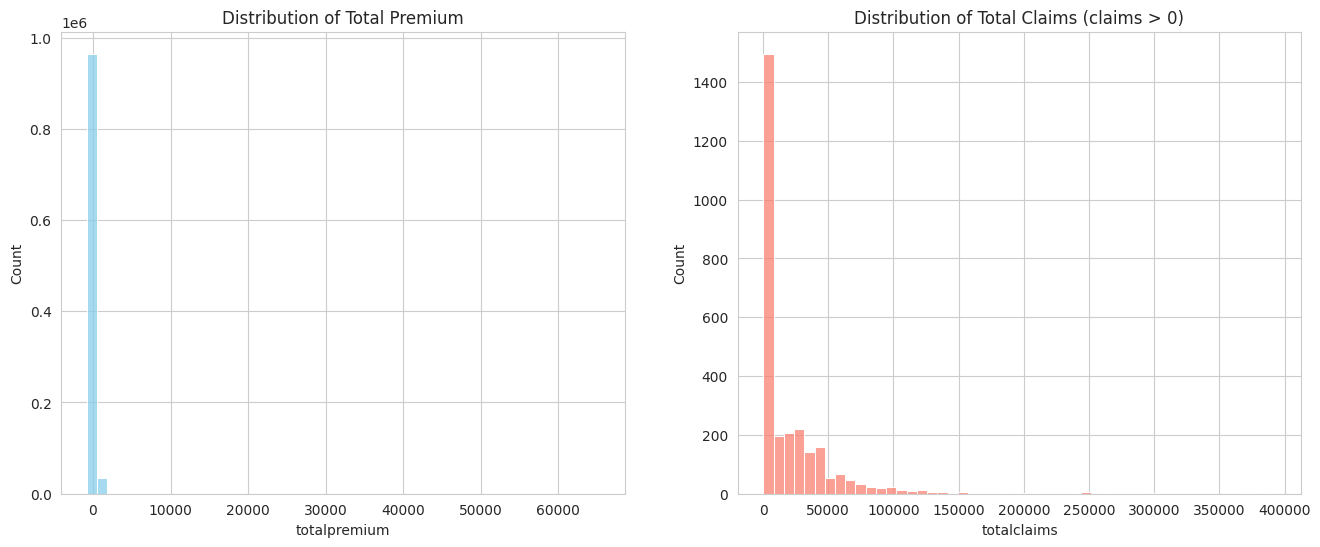

Successfully converted 'transactionmonth' to datetime objects.


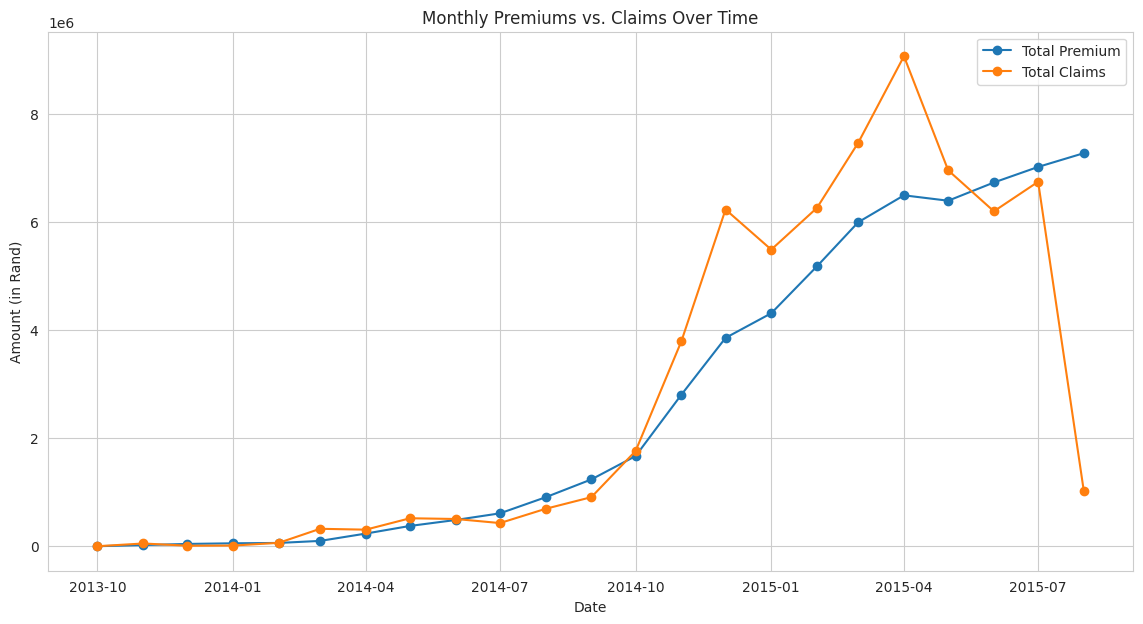


Top 10 Vehicle Makes by Average Claim Amount:
                                              mean  count
make                                                     
POLARSUN                             125197.843333      1
HYUNDAI                               56663.492325      8
B.A.W                                 47856.245614      6
GOLDEN JOURNEY                        46169.723522     27
MERCEDES-BENZ                         34079.340852      7
IVECO                                 31495.539656     24
AUDI                                  30939.506443     33
VOLKSWAGEN                            30150.485741     61
CMC                                   30082.171180     44
FIAT                                  26721.907895      4


In [3]:

# Create lossratio column for analysis
df['lossratio'] = df['totalclaims'] / df['totalpremium'].replace(0, np.nan)

# Q1: What is the overall Loss Ratio? How does it vary?
overall_loss_ratio = df['totalclaims'].sum() / df['totalpremium'].sum()
print(f"\nOverall Portfolio Loss Ratio: {overall_loss_ratio:.2%}")

# Loss Ratio by Province
province_loss_ratio = df.groupby('province')['lossratio'].mean().sort_values(ascending=False)
print("\nAverage Loss Ratio by Province:")
print(province_loss_ratio)

# Q2: Distributions of key financial variables
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['totalpremium'], bins=50, ax=axes[0], color='skyblue').set_title('Distribution of Total Premium')
sns.histplot(df[df['totalclaims'] > 0]['totalclaims'], bins=50, ax=axes[1], color='salmon').set_title('Distribution of Total Claims (claims > 0)')
plt.show()

try:
    df['transactiondate'] = pd.to_datetime(df['transactionmonth'])
    print("Successfully converted 'transactionmonth' to datetime objects.")

    # Now, proceed with the rest of the temporal analysis
    monthly_summary = df.groupby('transactiondate').agg(
        totalpremium=('totalpremium', 'sum'),
        totalclaims=('totalclaims', 'sum')
    ).reset_index()

    # Plotting the trends over time
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_summary['transactiondate'], monthly_summary['totalpremium'], label='Total Premium', marker='o')
    plt.plot(monthly_summary['transactiondate'], monthly_summary['totalclaims'], label='Total Claims', marker='o')
    plt.title('Monthly Premiums vs. Claims Over Time')
    plt.xlabel('Date')
    plt.ylabel('Amount (in Rand)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during datetime conversion: {e}")
    # If this fails, it might be due to a few rogue non-date values.
    # We can force errors to become NaT (Not a Time) and then handle them.
    # print("Attempting to convert with errors='coerce'...")
    # df['transactiondate'] = pd.to_datetime(df['transactionmonth'], errors='coerce')
    # print(f"Number of rows that could not be converted: {df['transactiondate'].isnull().sum()}")

# Q4: Which vehicle makes are associated with high/low claims?
claims_df = df[df['totalclaims'] > 0]
make_claims = claims_df.groupby('make')['totalclaims'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
print("\nTop 10 Vehicle Makes by Average Claim Amount:")
print(make_claims.head(10))

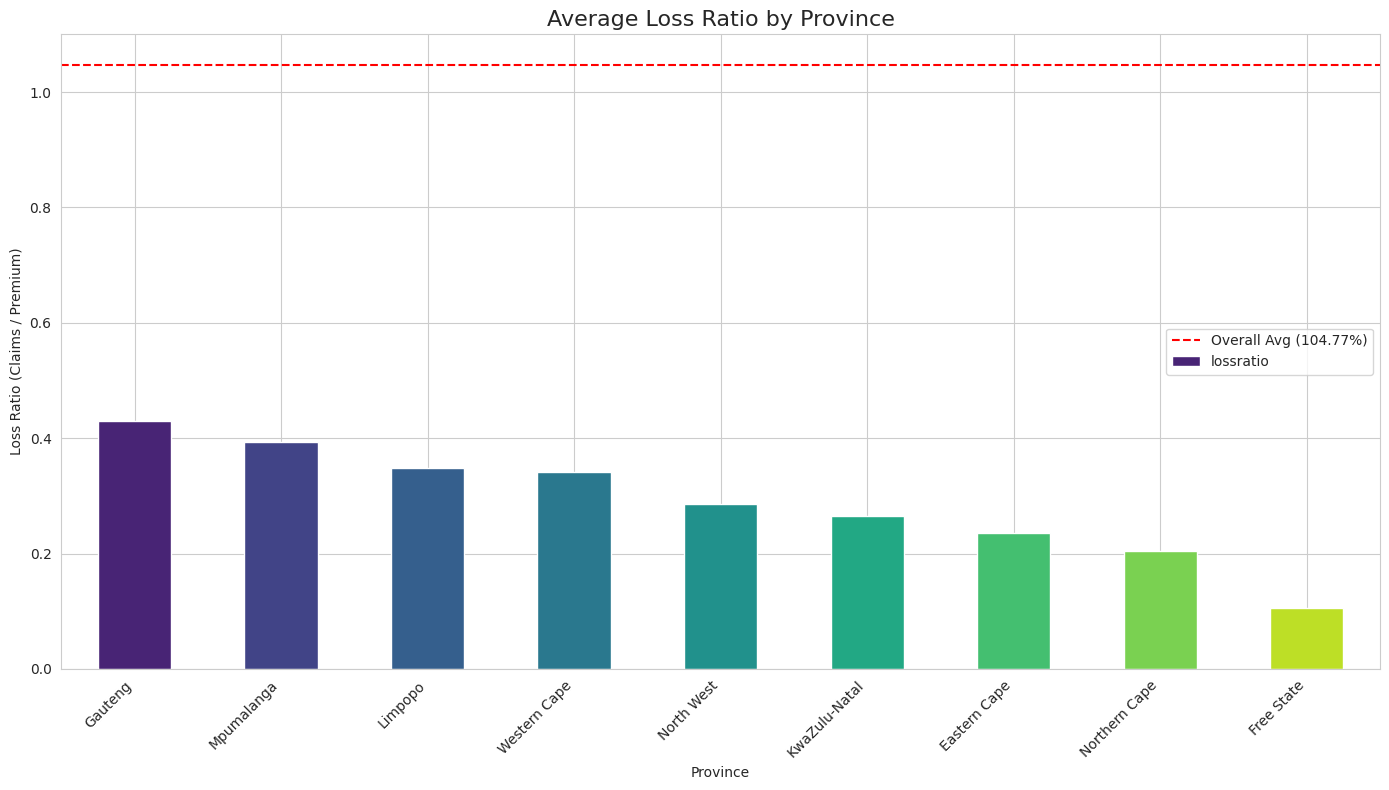

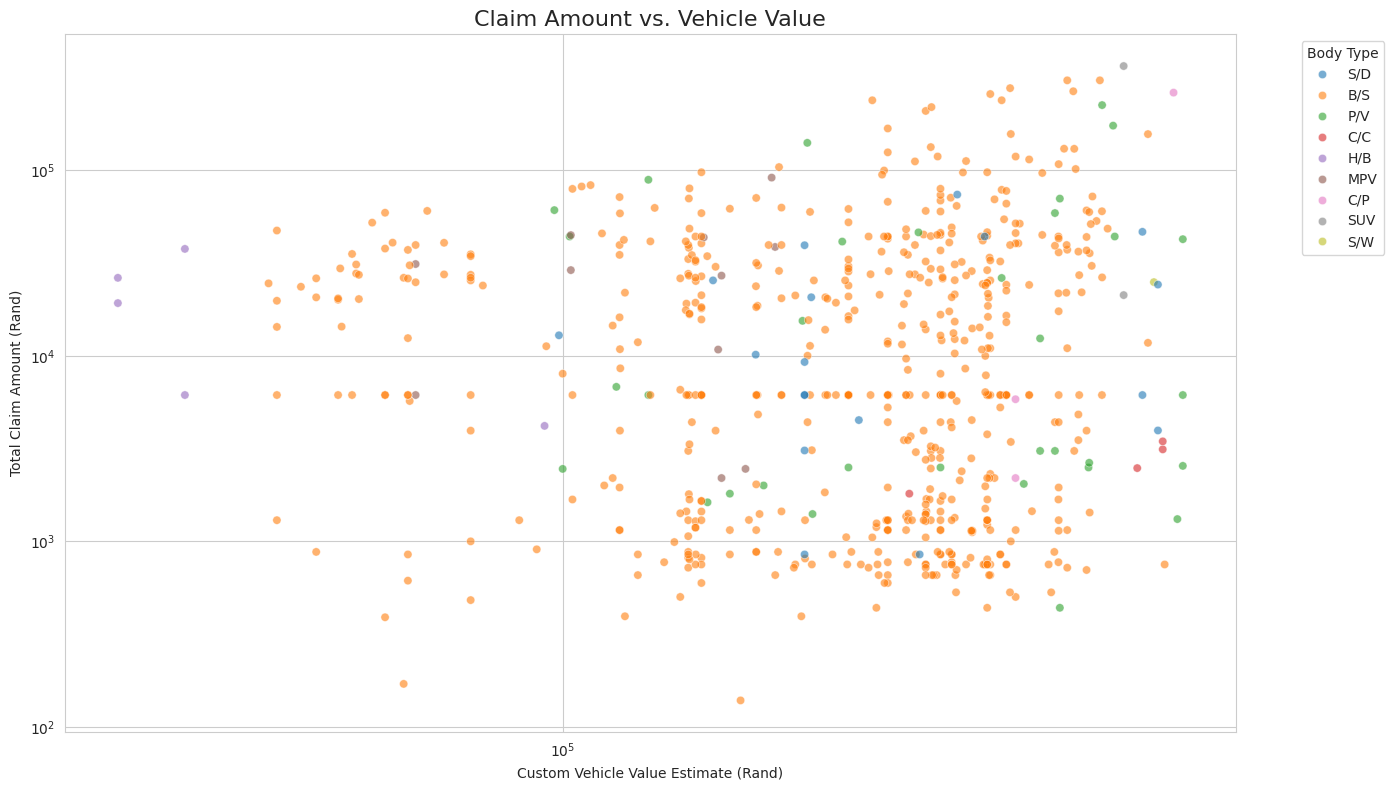

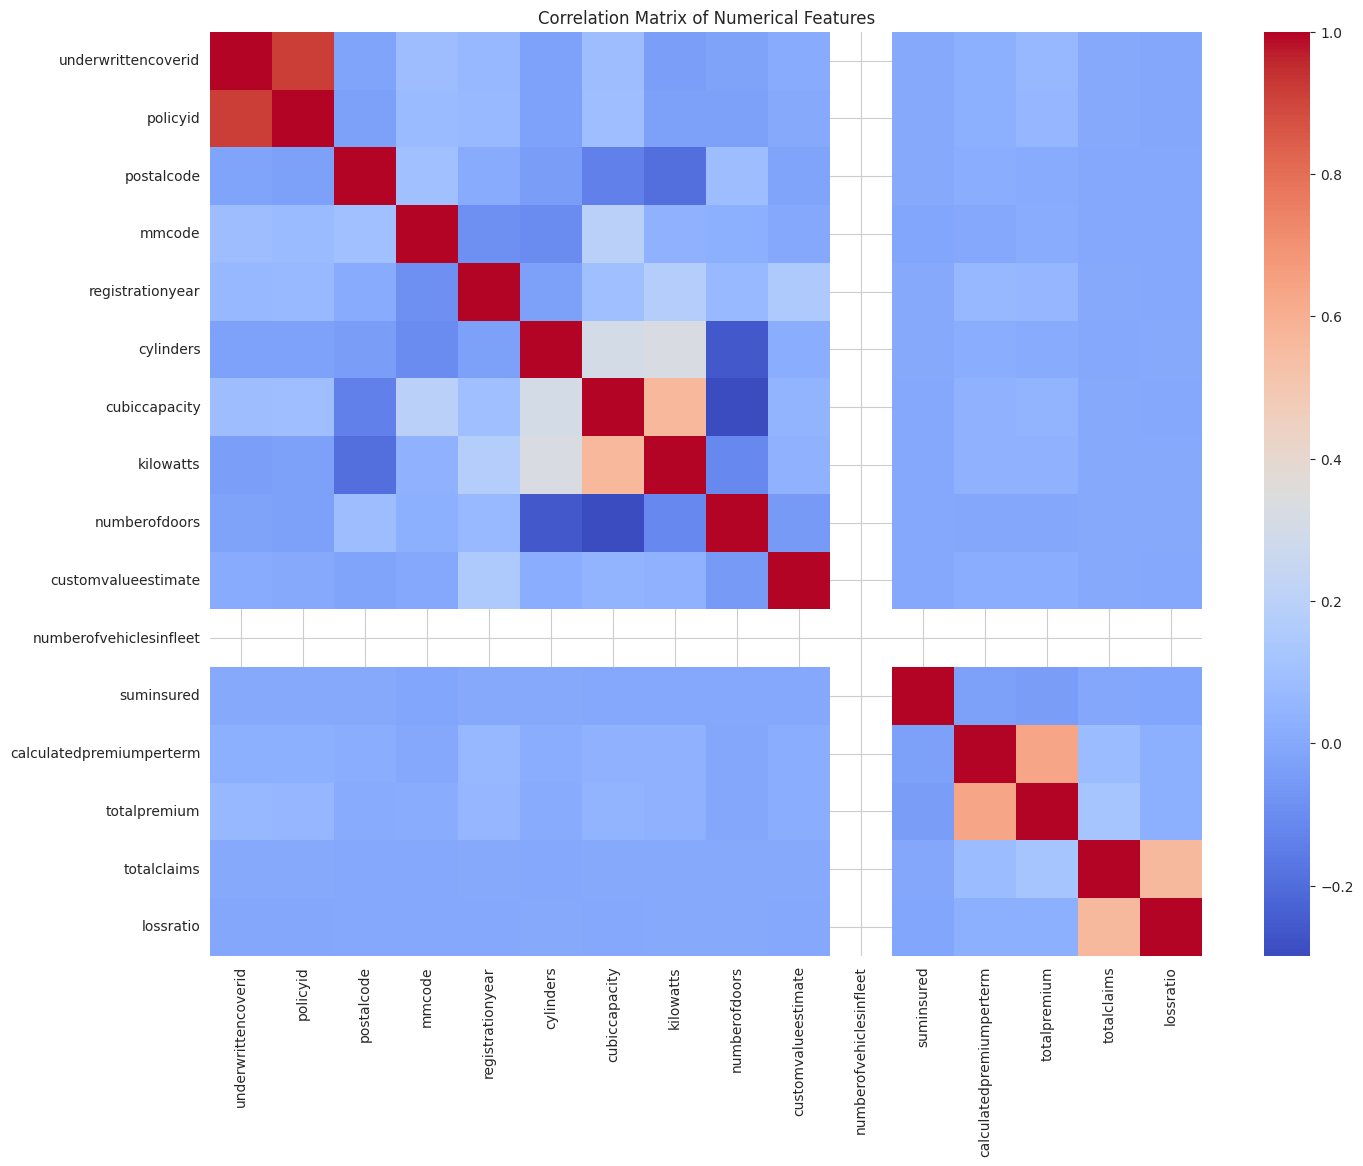

In [4]:
# Plot 1: Loss Ratio by Province
plt.figure(figsize=(14, 8))
province_loss_ratio.plot(kind='bar', color=sns.color_palette("viridis", len(province_loss_ratio)))
plt.axhline(y=overall_loss_ratio, color='r', linestyle='--', label=f'Overall Avg ({overall_loss_ratio:.2%})')
plt.title('Average Loss Ratio by Province', fontsize=16)
plt.ylabel('Loss Ratio (Claims / Premium)')
plt.xlabel('Province')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Claim Severity vs. Vehicle Value
plt.figure(figsize=(14, 8))
# Note the lowercase column names in the data access arguments
sns.scatterplot(
    data=df[(df['totalclaims'] > 0) & (df['customvalueestimate'] > 0)],
    x='customvalueestimate',
    y='totalclaims',
    hue='bodytype',
    alpha=0.6
)
plt.title('Claim Amount vs. Vehicle Value', fontsize=16)
plt.xlabel('Custom Vehicle Value Estimate (Rand)')
plt.ylabel('Total Claim Amount (Rand)')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Body Type', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

# Plot 3: Correlation Heatmap
numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()